In [1]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2


# Read data

In [2]:
df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'lineage_id',
                                                             'donor', 
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[(df.vdj_sequence.notna()) & (df.lineage_id.notna())]
df['donor_tissue'] = df['donor'] + "_" + df['tissue']

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid_gex']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid_gex']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid_gex']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)].copy()
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
unhypermutated = df_clean.v_mismatch < 1
# print(df_clean.celltype.value_counts())
# df_clean.loc[naive & (df_clean.v_mismatch > 0), 'celltype'] = 'Memory B cells'
# print(df_clean.celltype.value_counts())

permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]
df_clean = df_clean[~df_clean.celltype.str.startswith('Plasma')]


In [3]:
lineage_sizes = df.groupby(['donor','lineage_id']).size().to_dict()
df['lineage_size'] = df.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)
lineage_sizes = df_clean.groupby(['donor','lineage_id']).size().to_dict()
df_clean['lineage_size'] = df_clean.apply(lambda x: lineage_sizes[(x.donor, x.lineage_id)],
                             axis=1)

In [4]:
v_mismatch_dict = df[['vdj_sequence', 
                      'v_mismatch']].drop_duplicates(ignore_index=True).set_index('vdj_sequence')
v_mismatch_dict = v_mismatch_dict.to_dict()['v_mismatch']

celltype_dict = df_clean.groupby(['donor','lineage_id','vdj_sequence'])['celltype'].agg(list)
celltype_dict = celltype_dict.to_dict()
all_celltypes = df_clean.celltype.value_counts()
all_celltypes = all_celltypes[all_celltypes>10]

tissue_dict = df.groupby(['donor','lineage_id','vdj_sequence'])['tissue'].agg(list)
tissue_dict = tissue_dict.to_dict()
all_tissues = df.tissue.value_counts()
print(all_tissues)

isotype_dict = df.groupby(['donor','lineage_id','vdj_sequence'])['c_call'].agg(list)
isotype_dict = isotype_dict.to_dict()
all_isotypes = df.c_call.value_counts()
all_isotypes = all_isotypes[all_isotypes>300]
print(all_isotypes)


BM    465824
LN    310026
SP    204151
PB    180736
Name: tissue, dtype: int64
IGHM     451812
IGHA1    217365
IGHG1    214664
IGHG2    115329
IGHD      90095
IGHA2     34071
IGHG3     30323
IGHG4      6469
IGHE        337
Name: c_call, dtype: int64


In [5]:
test_variables = [('tissue', tissue_dict, all_tissues, tissue_colors),
                  ('celltype', celltype_dict, all_celltypes, bcelltype_colors_alt),
                  ('isotype', isotype_dict, all_isotypes, IGH_colors)]

# Drop down to unique vdj sequences

In [6]:
full_df = df.copy()
df = df[['vdj_sequence','donor','lineage_id', 'v_mismatch']].drop_duplicates(ignore_index=True)
df['lineage_uid'] = df['donor'] + "_" + df['lineage_id'].astype(str)

# Define statistics to quantify relative amounts of hypermutation of sequence within lineage

In [7]:
new_df = df.copy()

for variable_tuple in test_variables:
    variable, variable_dict, all_variable_counts, palette = variable_tuple
    for label in all_variable_counts.index:
        new_df[label] = new_df.apply(lambda x: label in variable_dict.get((x.donor,
                                                                x.lineage_id,
                                                                x.vdj_sequence), []), axis=1)
lineage_sizes = new_df.groupby('lineage_uid').size()
mut_min_max = new_df.groupby(['lineage_uid'])['v_mismatch'].agg(['min','max','mean','median'])
new_df['lineage_size'] = new_df.lineage_uid.map(lineage_sizes)
new_df['lineage_size_rank'] = new_df.groupby(['donor'])['lineage_size'].rank(method='first')#.astype(str)
print("Started with ", new_df.lineage_uid.nunique(), "lineages in entire dataset")
new_df = new_df[new_df.lineage_size > 4]
print("Retaining only lineages with at least 5 unique sequences, a total of ", new_df.lineage_uid.nunique(), "lineages")

new_df['v_mismatch'] = new_df.vdj_sequence.map(v_mismatch_dict)
new_df['hm_rank']= new_df.groupby(['lineage_uid'])['v_mismatch'].rank(method='first')
new_df['hm_level'] = new_df.apply(lambda x:
                                                 (x.v_mismatch - mut_min_max.loc[x.lineage_uid,'min'])/
                                                  ( mut_min_max.loc[x.lineage_uid,'max'] - 
                                                   mut_min_max.loc[x.lineage_uid,'min']), 
                                                  axis=1)
new_df['hm_diff'] = new_df.apply(lambda x:
                                                 (x.v_mismatch - mut_min_max.loc[x.lineage_uid,'min']), 
                                                  axis=1)

Started with  544758 lineages in entire dataset
Retaining only lineages with at least 5 unique sequences, a total of  9172 lineages


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1491271495.py:20: RuntimeWarning: invalid value encountered in double_scalars
  (x.v_mismatch - mut_min_max.loc[x.lineage_uid,'min'])/


BM


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


LN


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


SP


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


PB


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


Naive B cells


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


ASC-3


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


ASC-2


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


ASC-1


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


Memory B cells


/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11064/1474663495.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]


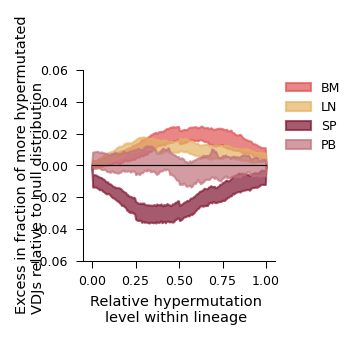

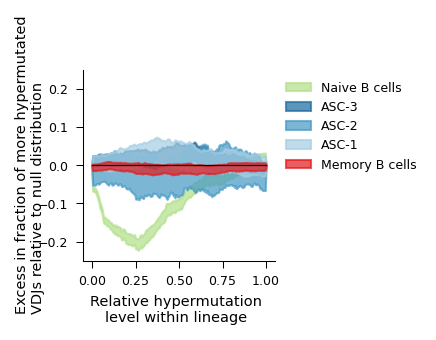

In [34]:
layout = {'tissue':(1,1),
          'celltype':(1,1)}

xvals = np.linspace(-0.001,1,200)

def calculate_complementary_cdf(xvals, yvals):
    complementary_cdf = np.asarray([(yvals>x).sum() for x in xvals])
    complementary_cdf = complementary_cdf/complementary_cdf[0]
    return complementary_cdf

figures = {'tissue':'Figure3','celltype':'Figure4'}
for stat in ['hm_level']:
    for variable_tuple in test_variables:
        variable, variable_dict, all_variable_counts, palette = variable_tuple
        nvars = len(all_variable_counts)
        if not(variable in layout.keys()):
            continue
        nrows, ncols = layout[variable]
        fig, ax = plt.subplots(nrows,ncols, figsize=(1.5*ncols+0.15,1.5*nrows+0.15), sharex=True, sharey=True)
        if ncols*nrows>1:
            ax = ax.flatten()
            if len(ax) > len(all_variable_counts):
                for it in range(len(all_variable_counts), len(ax)):
                    ax[it].remove()
        else:
            pass

        
        if variable == 'celltype':
            categories = ['Naive B cells','ASC-3', 'ASC-2', 'ASC-1', 'Memory B cells']
            # variable = 'common_celltype'
            # categories = ['ABCs', 'GC B cells', 'ASC-4']
            # variable = 'rare_celltype'
        else:
            categories = all_variable_counts.index
        for i, label in enumerate(categories):
            print(label)
            if ncols*nrows==1:
                axes = ax   
            else:
                axes = ax[i]

            bbox = axes.get_position()
            x, y, w, h = bbox.bounds

            inset_x, inset_y = x + w*0.6, y + h*0.6
            inset_w, inset_h = w*0.3, h*0.3

            # inset_ax = fig.add_axes([inset_x, inset_y, inset_w, inset_h])
            # inset_ax.tick_params(direction='in', length=0.5, width=1, labelsize=6, pad=1)

            #first calculate data stats and plot 1-1 line with null
            yvals = new_df.loc[new_df[label] & new_df.v_mismatch > 0, stat].values
            data_fraction = calculate_complementary_cdf(xvals, yvals)
            axes.plot(xvals, np.zeros(len(xvals)), color='k', lw=0.5)
            # now plot_permutations
            n = new_df[label].sum()

            weight_dict = ((new_df[new_df.v_mismatch > 0].groupby(['lineage_uid'])[label].sum())
                           /(new_df[new_df.v_mismatch > 0].groupby(['lineage_uid']).size())).to_dict()
            weights = new_df.lineage_uid.map(weight_dict)
            subsets = []
            for it in range(100):
                random_subset = new_df.sample(n, weights=weights)[new_df.v_mismatch > 0]

                resample_fraction = calculate_complementary_cdf(xvals, random_subset[stat].values)
                subsets.append(resample_fraction)
            
            subsets = np.asarray(subsets)
            subset_min = np.min(subsets, axis=0)
            subset_max = np.max(subsets, axis=0)
            # axes.fill_between(xvals, 
            #                   -np.log(subset_min/data_fraction)/np.log(2), 
            #                   -np.log(subset_max/data_fraction)/np.log(2), 
            #                    color=palette[label], 
            #                    alpha=0.8, 
            #                    lw=0.3)

            axes.fill_between(xvals,
                              -subset_min + data_fraction,
                              -subset_max + data_fraction,
                              color=palette[label], 
                              alpha=0.7, 
                              lw=1,
                              label=label)
            axes.set_xlabel('')
            axes.set_ylabel('')
            if ncols*nrows> 1:
                axes.text(0.05,0.9,f"{label}", fontsize=7, transform=axes.transAxes)

            if 'celltype' in variable:
                axes.set_ylim([-0.25,0.25])
            else:
                axes.set_ylim([-0.06,0.06])

        sns.despine(fig)
        axes.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
        if ncols*nrows > 1:
            fig.supylabel('Excess in fraction of more hypermutated\nVDJs relative to null distribution', fontsize=7)
            fig.supxlabel("Relative hypermutation level within lineage", fontsize=7)
            ax[4].legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')

            fig.tight_layout()
        else:
            fig.supylabel('Excess in fraction of more hypermutated\nVDJs relative to null distribution', fontsize=7, x = -0.15)
            fig.supxlabel("Relative hypermutation\nlevel within lineage", fontsize=7, y= -0.15)
            axes.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')


        fig.savefig(f'{FIGURE_OUTDIR}/{figures[variable]}/{variable}_distributions_within_lineage.pdf', bbox_inches='tight')

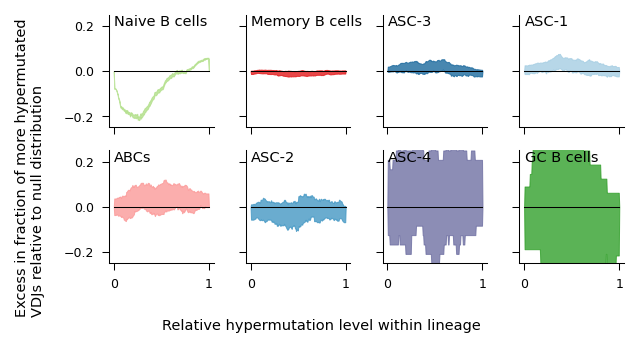

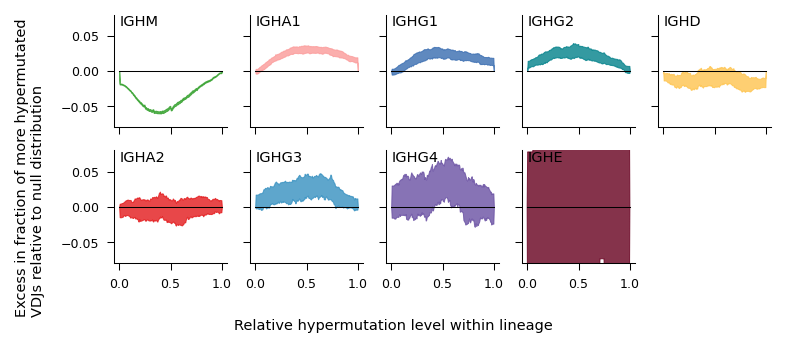

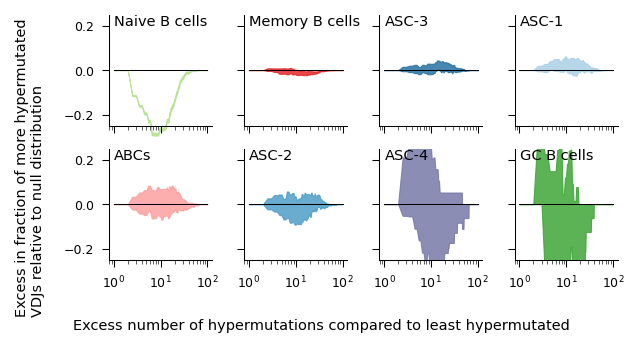

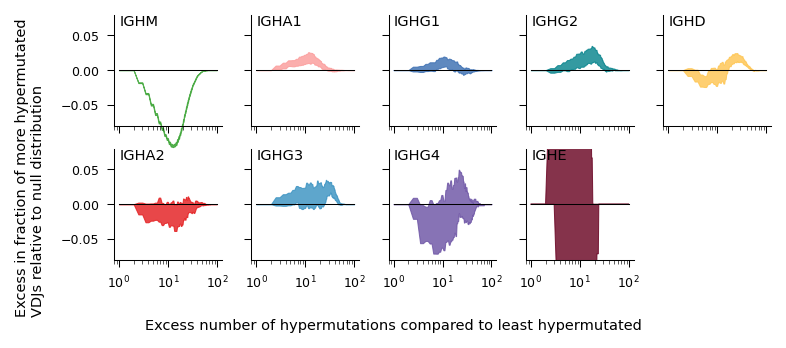

In [9]:
layout = {'celltype':(2,4),
          'isotype':(2,5)}

figures = {'hm_level':'EDFigure6', 'hm_diff':'EDFigure7'}
xvals_options = {'hm_level':np.linspace(-0.001,1,200),  
                 'hm_diff':np.linspace(1,100,200)}

xlabels = {'hm_level':'Relative hypermutation level within lineage',
              'hm_diff':'Excess number of hypermutations compared to least hypermutated'}   

def calculate_complementary_cdf(xvals, yvals):
    complementary_cdf = np.asarray([(yvals>x).sum() for x in xvals])
    complementary_cdf = complementary_cdf/complementary_cdf[0]
    return complementary_cdf

for stat in ['hm_level', 'hm_diff']:
    xvals = xvals_options[stat]
    for variable_tuple in test_variables:
        variable, variable_dict, all_variable_counts, palette = variable_tuple
        nvars = len(all_variable_counts)
        if not(variable in layout.keys()):
            continue
        nrows, ncols = layout[variable]
        fig, ax = plt.subplots(nrows,ncols, figsize=(1.*ncols+0.25,1*nrows+0.25), sharex=True, sharey=True)
        if ncols*nrows>1:
            ax = ax.flatten()
            if len(ax) > len(all_variable_counts):
                for it in range(len(all_variable_counts), len(ax)):
                    ax[it].remove()
        else:
            pass

        
        if variable == 'celltype':
            # categories = ['ASC-3', 'ASC-2', 'ASC-1', 'Memory B cells', 'Naive B cells']
            # variable = 'common_celltype'
            # categories = ['ABCs', 'GC B cells', 'ASC-4']
            # variable = 'rare_celltype'
            categories=all_variable_counts.index
        else:
            categories = all_variable_counts.index
        for i, label in enumerate(categories):
            if ncols*nrows==1:
                axes = ax   
            else:
                axes = ax[i]

            bbox = axes.get_position()
            x, y, w, h = bbox.bounds

            inset_x, inset_y = x + w*0.6, y + h*0.6
            inset_w, inset_h = w*0.3, h*0.3

            # inset_ax = fig.add_axes([inset_x, inset_y, inset_w, inset_h])
            # inset_ax.tick_params(direction='in', length=0.5, width=1, labelsize=6, pad=1)

            #first calculate data stats and plot 1-1 line with null
            yvals = new_df.loc[new_df[label] & new_df.v_mismatch > 0, stat].values
            data_fraction = calculate_complementary_cdf(xvals, yvals)
            axes.plot(xvals, np.zeros(len(xvals)), color='k', lw=0.5)
            # now plot_permutations
            n = new_df[label].sum()

            weight_dict = ((new_df[new_df.v_mismatch > 0].groupby(['lineage_uid'])[label].sum())
                           /(new_df[new_df.v_mismatch > 0].groupby(['lineage_uid']).size())).to_dict()
            weights = new_df.lineage_uid.map(weight_dict)

            subsets = []
            for it in range(100):
                random_subset = new_df[new_df.v_mismatch > 0].sample(n, weights=weights)

                resample_fraction = calculate_complementary_cdf(xvals, random_subset[stat].values)
                subsets.append(resample_fraction)
            
            subsets = np.asarray(subsets)
            subset_min = np.min(subsets, axis=0)
            subset_max = np.max(subsets, axis=0)
            # axes.fill_between(xvals, 
            #                   -np.log(subset_min/data_fraction)/np.log(2), 
            #                   -np.log(subset_max/data_fraction)/np.log(2), 
            #                    color=palette[label], 
            #                    alpha=0.8, 
            #                    lw=0.3)

            axes.fill_between(xvals,
                              -subset_min + data_fraction,
                              -subset_max + data_fraction,
                              color=palette[label], 
                              alpha=0.8, 
                              lw=0.5,
                              label=label, 
                              clip_on = i > 0)
            axes.set_xlabel('')
            axes.set_ylabel('')
            if ncols*nrows> 1:
                axes.text(0.05,0.9,f"{label}", fontsize=7, transform=axes.transAxes)

            if 'celltype' in variable:
                axes.set_ylim([-0.25,0.25])
            else:
                axes.set_ylim([-0.08,0.08])

            if stat in ['hm_diff']:
               axes.set_xscale('log')

            

        sns.despine(fig)
        if ncols*nrows > 1:
            # axes.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
            fig.supylabel('Excess in fraction of more hypermutated\nVDJs relative to null distribution', fontsize=7)
            fig.supxlabel(xlabels[stat], fontsize=7)
            # ax[4].legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')

            fig.tight_layout()
        else:
            fig.supylabel('Excess in fraction of more hypermutated\nVDJs relative to null distribution', fontsize=7, x = -0.1)
            fig.supxlabel(xlabels[stat], fontsize=7, y= -0.15)
            axes.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')


        fig.savefig(f'{FIGURE_OUTDIR}/{figures[stat]}/{variable}_{stat}_distributions_within_lineage.pdf', bbox_inches='tight')

In [10]:
cols=['donor','lineage_id','vdj_sequence','tissue','v_mismatch', 'c_call']
lineage_representation = full_df.groupby(['donor','lineage_id','tissue']).size()
lineage_representation = lineage_representation.reset_index().pivot(index=['donor','lineage_id'],
                                                                    columns='tissue',
                                                                    values=0).fillna(0)
lineage_representation = lineage_representation > 0
unique_vdj_df = full_df[full_df.v_mismatch>0].groupby(cols).size().reset_index()
memory_b_cell_df = df_clean[(df_clean.v_mismatch>0) & (df_clean.celltype=='Memory B cells')].groupby(cols).size().reset_index()

for tissue in lineage_representation.columns:
    memory_b_cell_df[tissue] = memory_b_cell_df.apply(lambda x: lineage_representation.loc[(x.donor,x.lineage_id),tissue],axis=1)



PB 11.0
BM 23.0
LN 16.0
SP 11.0


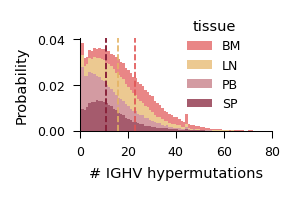

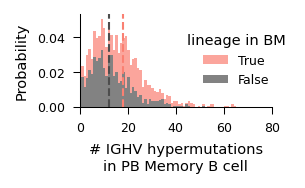

In [11]:
fig, ax = plt.subplots(1,1,figsize=(1.65,0.8))
h=sns.histplot(data=unique_vdj_df.groupby('tissue').sample(n=unique_vdj_df.tissue.value_counts().min()), 
            x='v_mismatch', 
            hue='tissue', 
            palette=tissue_colors, 
            multiple='stack',
            ax = ax, 
            edgecolor='w',
            lw=0,
            bins = np.linspace(0,90,90)-0.5,
            common_norm=True,
            stat='probability',
            legend=True,
            alpha=0.7)
ax.set_xlim([0,80])

# Add vertical lines for medians
for tissue in unique_vdj_df.tissue.unique():
    tissue_data = unique_vdj_df[unique_vdj_df['tissue'] == tissue]['v_mismatch']
    print(tissue, np.median(tissue_data))

    ax.axvline(np.median(tissue_data), color=tissue_colors[tissue], linestyle='--', linewidth=0.8)

fig1, ax1 = plt.subplots(1,1,figsize=(1.65,0.8))
relevant_df = memory_b_cell_df[memory_b_cell_df.tissue=='PB']
relevant_df = relevant_df.groupby('BM').sample(n=relevant_df.BM.value_counts().min())
memb_palette = {False:'0.3', True:'salmon'}
g=sns.histplot(relevant_df, 
             x='v_mismatch', 
             hue='BM', 
             hue_order=[True,False],
             palette= memb_palette,
            multiple='stack',
            ax = ax1, 
            edgecolor='w',
            lw=0,
            bins = np.linspace(0,90,90)-0.5,
            common_norm=True,
            stat='probability',
            legend=True,
            alpha=0.7)
# Add vertical lines for medians
for value in relevant_df.BM.unique():
    tissue_data = relevant_df[relevant_df['BM'] == value]['v_mismatch']
    ax1.axvline(np.median(tissue_data), color=memb_palette[value], linestyle='--', linewidth=1)

sns.move_legend(h,loc='lower left', frameon=False, title='tissue', bbox_to_anchor=(0.5,0.1))
sns.move_legend(g,loc='lower left', frameon=False, title='lineage in BM', bbox_to_anchor=(0.5,0.1))
    
# BM_lineages = new_df.groupby('lineage_uid')['BM'].sum() > 0
# BM_lineages = BM_lineages[BM_lineages].index.values
# BM_lineages = new_df.lineage_uid.isin(BM_lineages)

ax1.set_xlim([0,80])

ax.set_xlabel('# IGHV hypermutations\n       ')
ax1.set_xlabel('# IGHV hypermutations\nin PB Memory B cell')
sns.despine(fig)
sns.despine(fig1)
# fig.tight_layout()
# fig1.tight_layout()

fig.savefig(f'{FIGURE_OUTDIR}/Figure3/tissue_hypermutation.pdf', bbox_inches='tight')
fig1.savefig(f'{FIGURE_OUTDIR}/Figure3/conditional_memB_hypermutation.pdf', bbox_inches='tight')

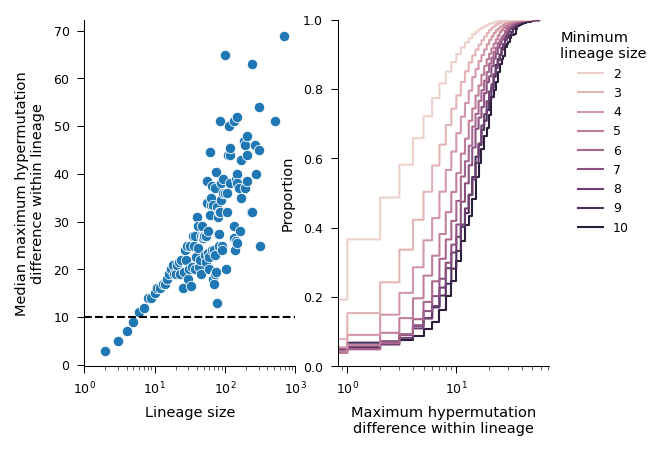

In [54]:
unique_vdj_df['lineage_uid'] = unique_vdj_df['donor'] + "_" + unique_vdj_df['lineage_id'].astype(str)
hm_range_by_size = unique_vdj_df.groupby(['lineage_uid'])['v_mismatch'].agg(['min','max']).reset_index()
hm_range_by_size['hm_diff'] = hm_range_by_size['max'] - hm_range_by_size['min']
hm_range_by_size['lineage_size'] = hm_range_by_size.lineage_uid.map(lineage_sizes)
hm_range_by_size = hm_range_by_size[hm_range_by_size.lineage_size > 1]

# fig, ax = plt.subplots(figsize=(4,3))
# sns.scatterplot(hm_range_by_size, x = 'lineage_size', y = 'hm_diff', alpha=0.1, ax =ax)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylabel('Maximum hypermutation difference')
# ax.set_xlabel('Lineage size');

fig, ax = plt.subplots(1,2, figsize=(4,3))

medians = hm_range_by_size.groupby(['lineage_size'])['hm_diff'].median().reset_index()
sns.scatterplot(data=medians, x='lineage_size', y='hm_diff', ax=ax[0])
ax[0].set_xscale('log')
ax[0].set_xlabel('Lineage size')
ax[0].set_ylabel("Median maximum hypermutation\ndifference within lineage")
ax[0].axhline(10, color='k', linestyle='--')
ax[0].set_xlim([1,1000])

g = sns.ecdfplot(data=hm_range_by_size[hm_range_by_size.lineage_size <= 10], x='hm_diff', hue='lineage_size', ax=ax[1])
sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False, title='Minimum\nlineage size')
ax[1].set_xscale('log')
ax[1].set_xlabel("Maximum hypermutation\ndifference within lineage")
sns.despine(fig)

